# Result comparaison for Superpixels Entropy

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data
import LambdaCoeff as LC

import SSGA

145 145 200


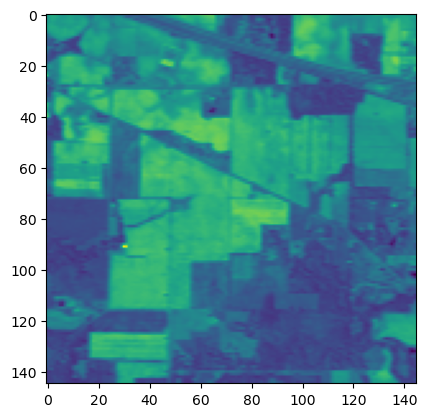

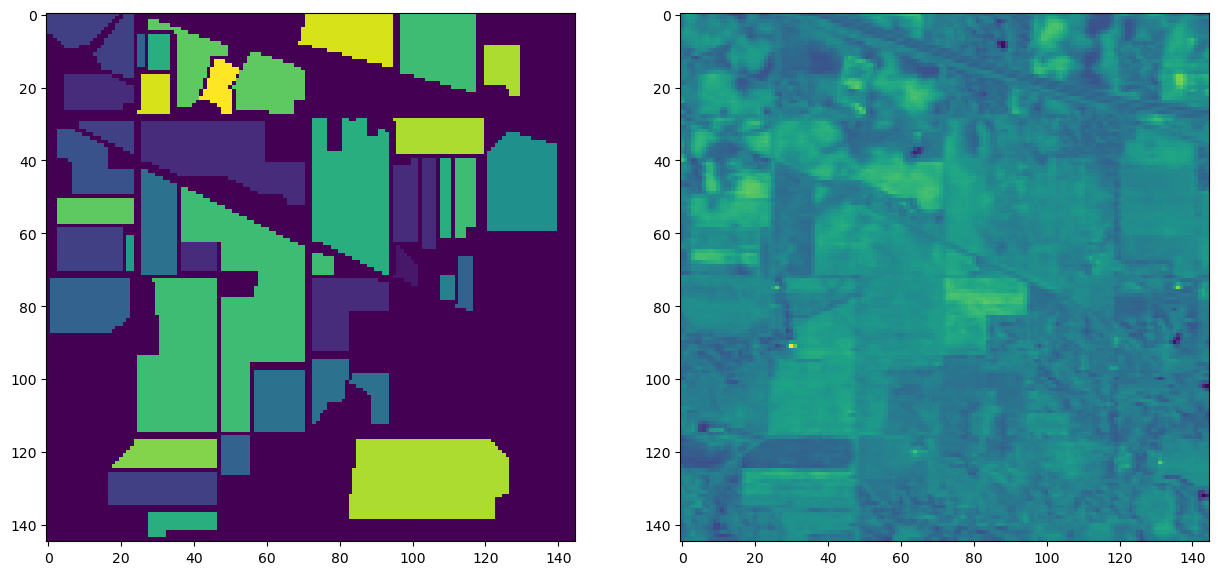

In [3]:
usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter


N,M,B = usedDataset["shape"]
trainData = usedDataset["data"]
print(N,M,B)

def crop_img(size):
    size = min(size, N, M)
    if size!=N and size!=M:
        xStart = np.random.randint(0, N-1-size)
        yStart = np.random.randint(0, M-1-size)
        trainData = usedDataset["data"][xStart:xStart+size, yStart:yStart+size, :]
        trainData = Data.standardize_data(trainData)
        N,M,B = trainData.shape
    return trainData
#trainData = crop_img(400)

b = np.random.randint(0, B-1)
plt.imshow(trainData[:,:,b])
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[1].imshow(np.average(usedDataset["data"], axis=2))
plt.show()

## Compute SPs

In [4]:
RunDataFormat = False
useLambdasModel = True

import json
datasetFolder = "datasets/"
saved_file_name = {
    True: "FormatDataSuperpixels",
    False: "SimFunSuperpixels"
}

complete_save_file_name = datasetFolder + saved_file_name[RunDataFormat]
if useLambdasModel and not RunDataFormat:
    complete_save_file_name += "UsedLambdasModel"
complete_save_file_name +=  usedDataset["name"] +".json"
print(complete_save_file_name)

datasets/SimFunSuperpixelsUsedLambdasModelIndian Pines.json


In [5]:
if RunDataFormat:
    data1 = usedDataset["data"].copy()
    data2 = Data.normalized_data(usedDataset["data"].copy())
    data3 = Data.standardize_data( usedDataset["data"].copy() )
    datas = [data1, data2, data3]
    names = ["Basic", "Normalized", "Standardized"]
else:
    datas = [ERS.complete_basic_similarity,
                        ERS.complete_norm2_similarity,
                        ERS.complete_norm1_similarity]
    names = ["Basic", "(.)²", "|.|"]
    trainData = Data.standardize_data(usedDataset["data"])
    getLambdas = [LC.getLambdaAverage, LC.getLambdaNorm2, LC.getLambdaNorm1]


FoundLambdaCoeffKey = "DataFormat" if RunDataFormat else "SimilarityFunction"
LambdaCoeffs = Data.FoundLambdaCoeff[FoundLambdaCoeffKey]
Ks = [300, 1100, 1300]
#Ks = list(LambdaCoeffs[usedDataset["name"]].keys())
if len(Ks)==1:
    complete_save_file_name = complete_save_file_name[:len(complete_save_file_name)-5] + str(Ks[0]) + "SP.json"
    print(complete_save_file_name)
Ks.sort(key=lambda x:x)

In [ ]:
def compute_SPs(Ks, save_data=False, find_lambda=True):
    SPsDic = {}
    for K in Ks:
        print("K:", K)
        Ps = LC.computePs(K, N, M)

        current_list = []
        for i,data in enumerate(datas):
            print(i, end=" ")
            if RunDataFormat:
                if find_lambda:
                    SPs, coeff = LC.dichotomies_search(data, K, 1, 400, ERS.complete_basic_similarity, Ps)
                    print("Choosen Coef:", coeff)
                else:
                    SPs = ERS.find_superpixel(data, K, LambdaCoeffs[usedDataset["name"]][K][i], ERS.complete_basic_similarity, True)
            else:
                if useLambdasModel:
                    SPs = ERS.find_superpixel(trainData, K, int(getLambdas[i](K,N,M)), data, True)
                else:
                    if find_lambda:
                        SPs, coeff = LC.dichotomies_search(trainData, K, 1, 500, data, Ps)
                        print("Choosen Coef:", coeff)
                    else:
                        SPs = ERS.find_superpixel(trainData, K, LambdaCoeffs[usedDataset["name"]][K][i], data, True)
            current_list.append(SPs)
        print()
        SPsDic[K] = current_list


    if save_data:
        json_object = json.dumps(SPsDic)
        with open(complete_save_file_name, "w") as f :
            f.write(json_object)
            f.close()
    return SPsDic


SPsDic = compute_SPs(Ks, save_data=True, find_lambda=False)

K: 300
0 1 2 
K: 1100
0 1 2 
K: 1300
0 1 2 


In [6]:
with open(complete_save_file_name, "r") as f:
    tempDic = json.load(f)
    f.close()
SPsDic = {}
for key, dataListe in tempDic.items():
    SPsDic[int(key)] = [[[tuple(coor) for coor in SP] for SP in SPsListe] for SPsListe in dataListe]

Ks = list(SPsDic.keys())
Ks.sort()

### Superpixels Classifier

In [7]:
ClassifierDic:dict[int, list[ERS.SuperpixelClassifier]] = {}
for b in [True, False]:
    ClassifierDic[b] = {}
    for K in Ks:
        ClassifierDic[b][K] = [
            ERS.SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"], counting0=b)
                    for SPs in SPsDic[K]
            ]

### Visual result

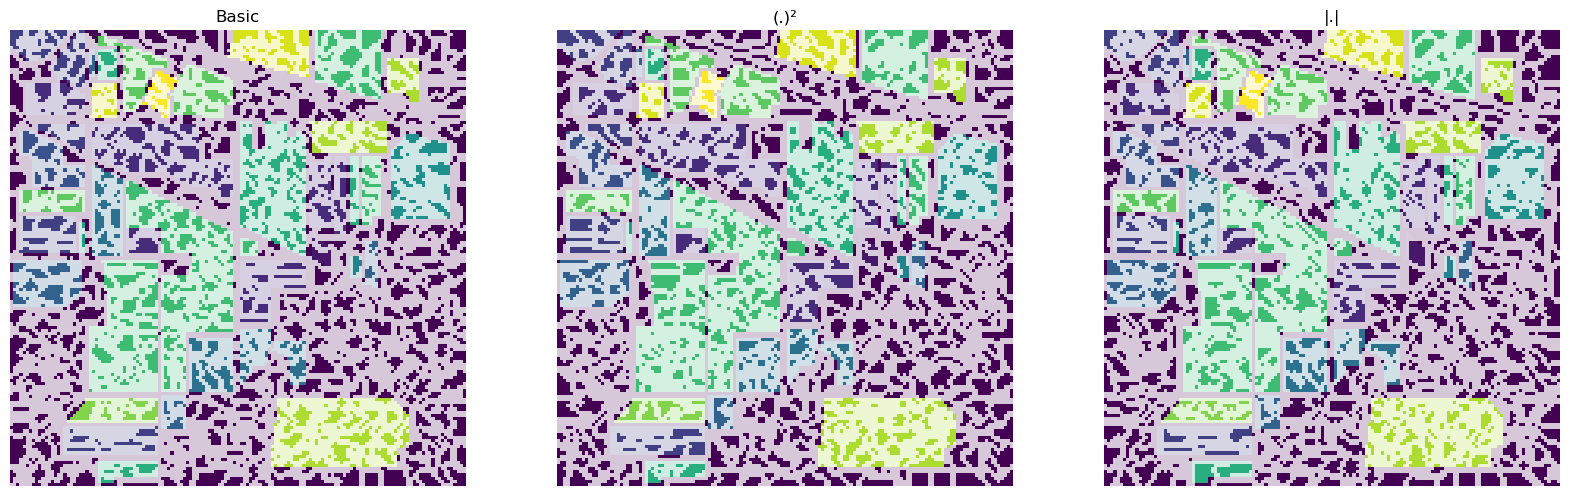

True


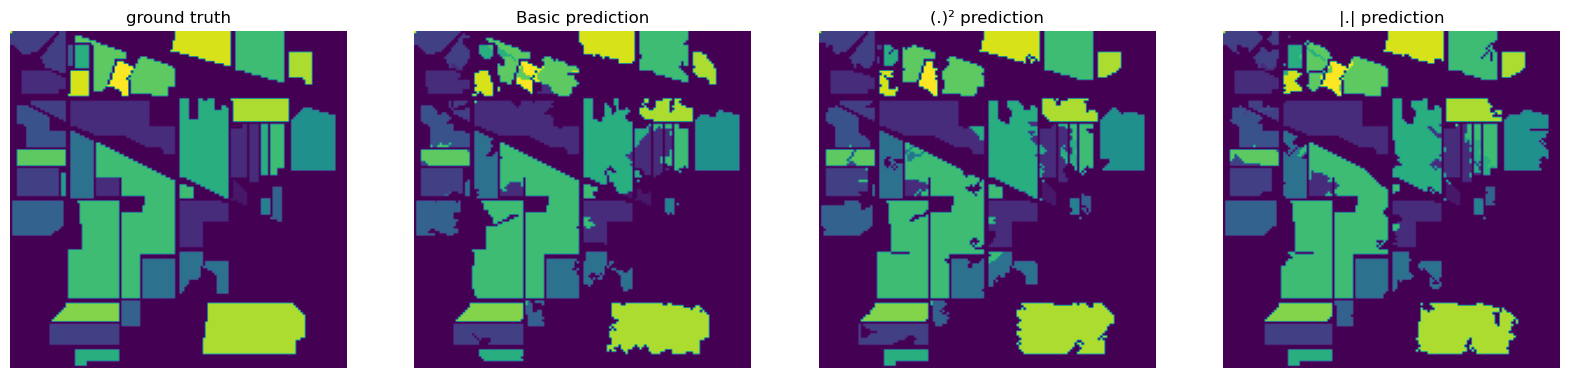

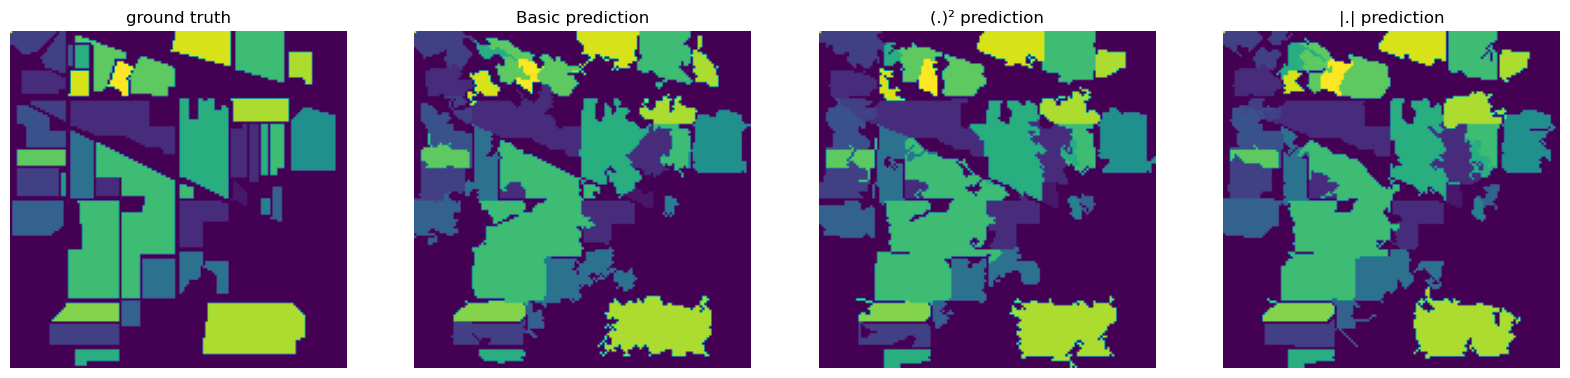

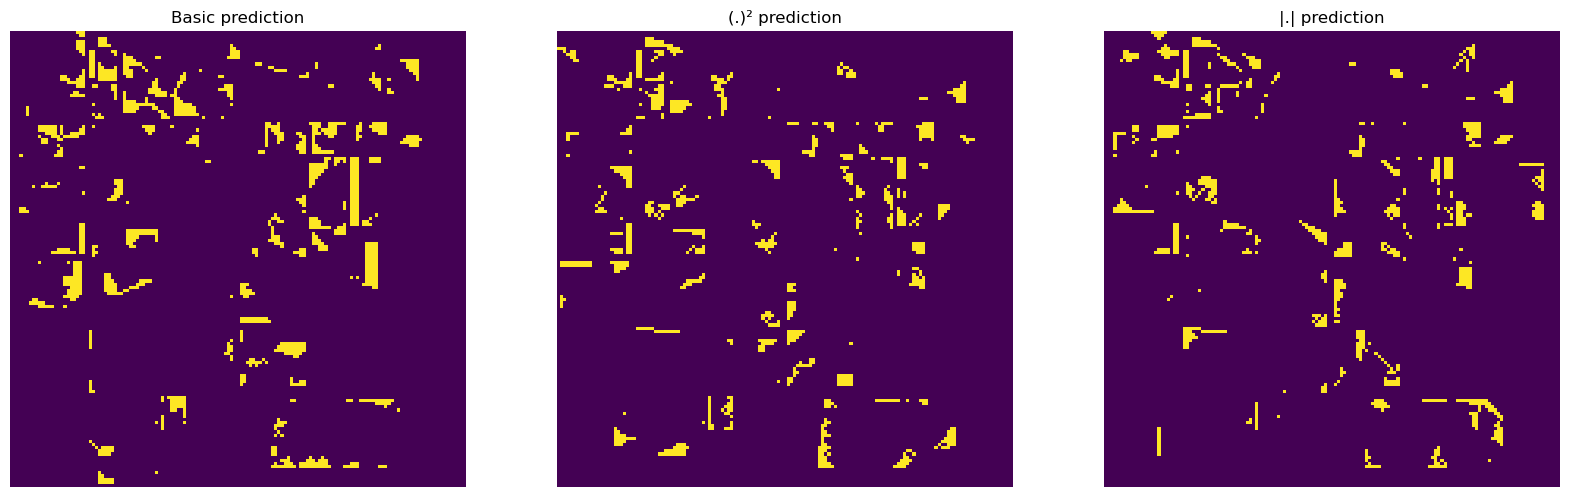

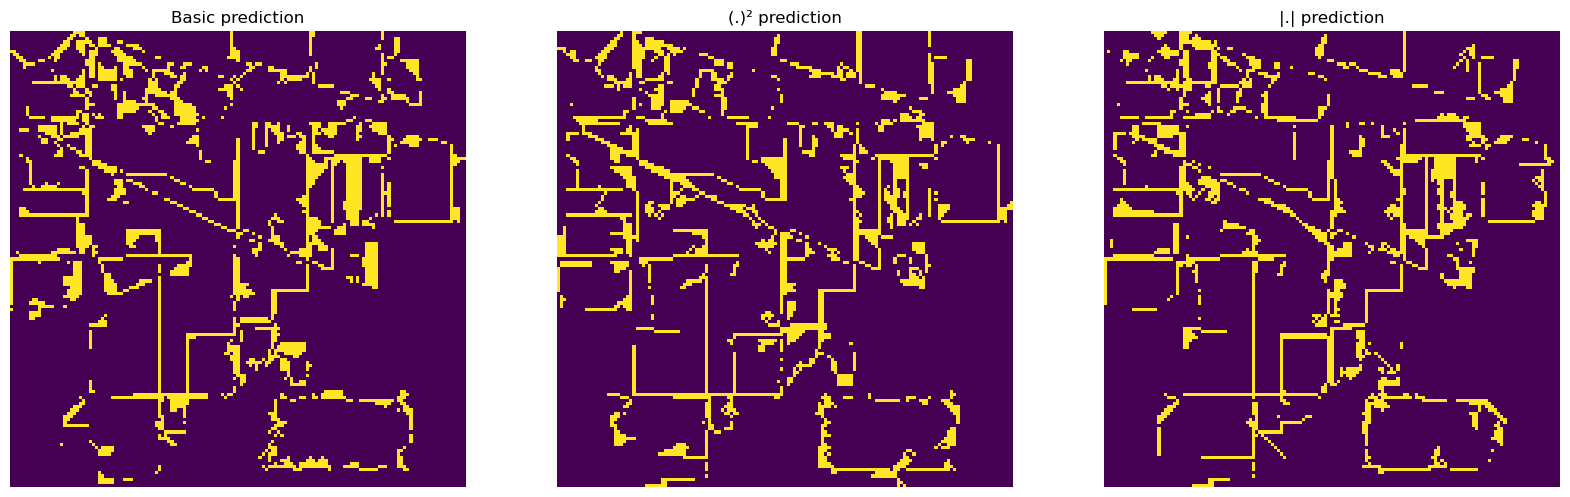

False


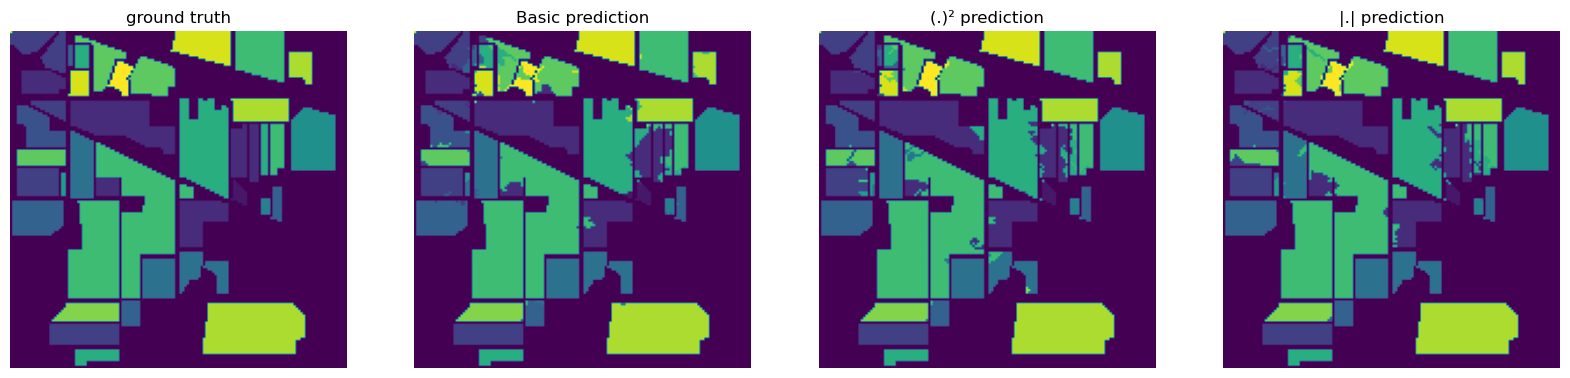

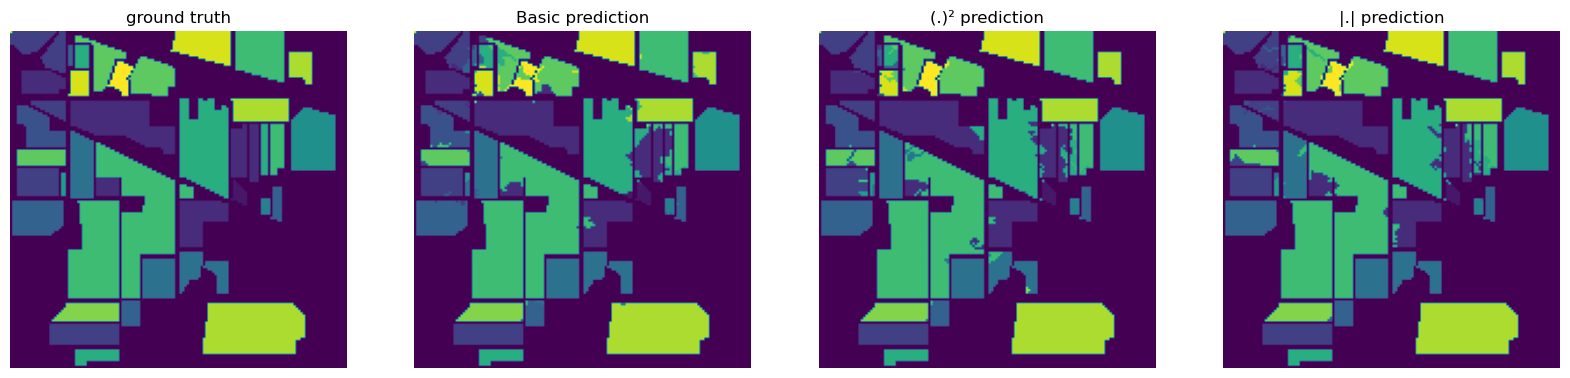

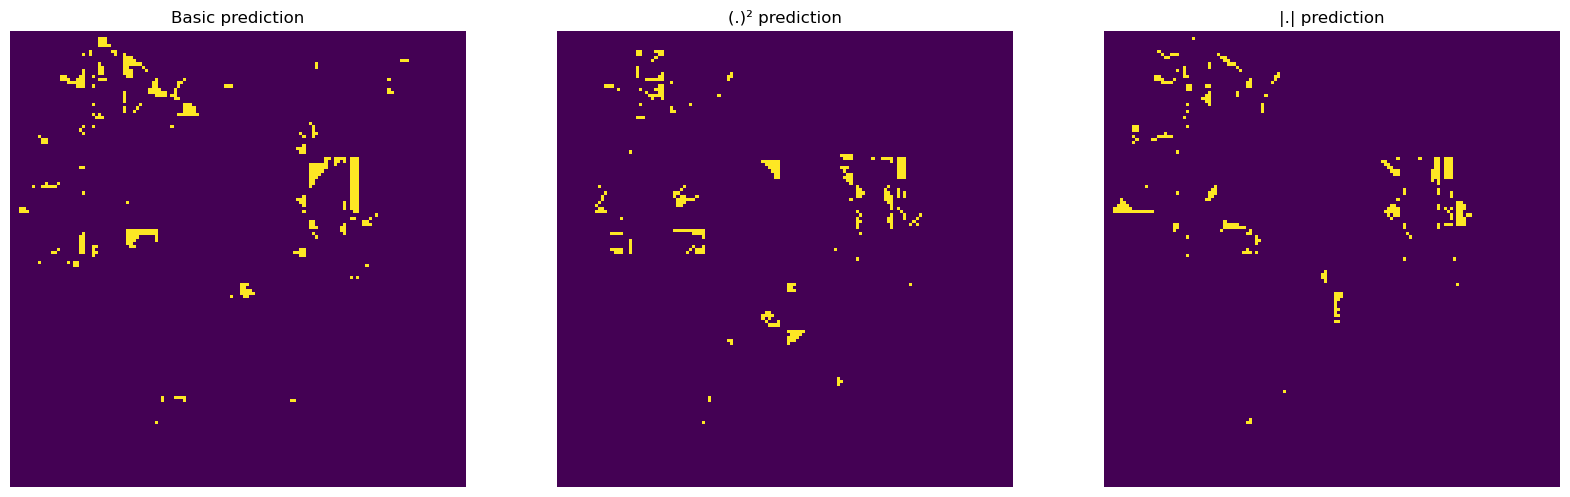

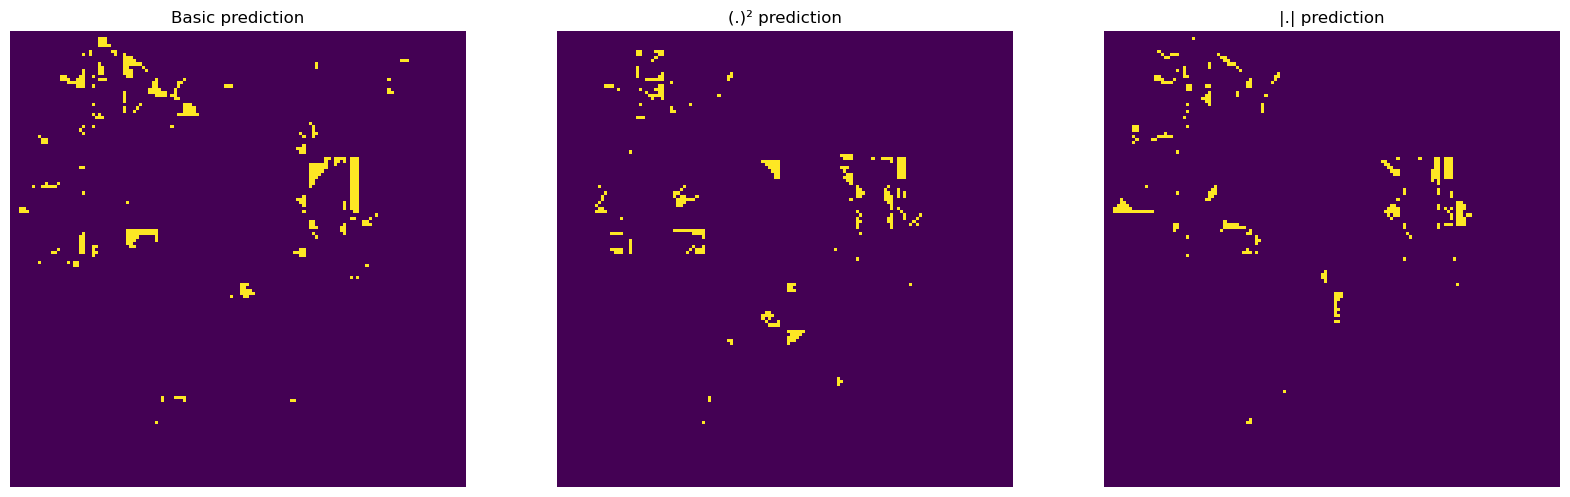

In [ ]:
K = 500

fig, axs = plt.subplots(1, len(SPsDic[K]))
fig.set_size_inches(20,30)
for i,SP in enumerate(SPsDic[K]):
    axs[i].imshow(usedDataset["gt"])
    axs[i].imshow(ERS.create_overlay_borders(usedDataset["gt"], SP, color=[255,255,255,200]))
    axs[i].title.set_text(names[i])
    axs[i].axis("off")
plt.show()



for b in [True, False]:
    print(b)
    classifiers = ClassifierDic[b][K]

    imgs = [usedDataset["gt"]] + [C.guess_map for C in classifiers]
    titles = ["ground truth"] + [name+" prediction" for name in names]


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]==0:
                    new_img[x,y] = 0
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img)
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img)
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=0 and usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()

    fig, axs = plt.subplots(1, len(classifiers))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()


### Classification result

In [9]:
size = len(ClassifierDic[True][Ks[0]])
overallAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageWeigthedJaccard = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
singleClassCounts = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageProportions = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}

labelsAccuracy = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}
labelsJaccard = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}

for b in [True, False]:
    print(b)
    for K in Ks:
        for i,C in enumerate(ClassifierDic[b][K]):
            overallAccuracys[b][K][i] = C.overallAccuracy(usedDataset["gt"])
            averageAccuracys[b][K][i] = C.averageAccuracy(usedDataset["gt"])
            averageWeigthedJaccard[b][K][i] = C.averageWeightedJaccard(usedDataset["gt"], usedDataset["class"])
            singleClassCounts[b][K][i] = C.singleClassProportion()
            averageProportions[b][K][i] = C.averageProportion()
        
            for label in usedDataset["labels"]:
                if label in C.labels:
                    labelsAccuracy[b][label][K][i] = C.labelAccuracy(usedDataset["class"], label)
                    labelsJaccard[b][label][K][i] = C.jaccard(usedDataset["gt"], usedDataset["class"], label)
        

True
False


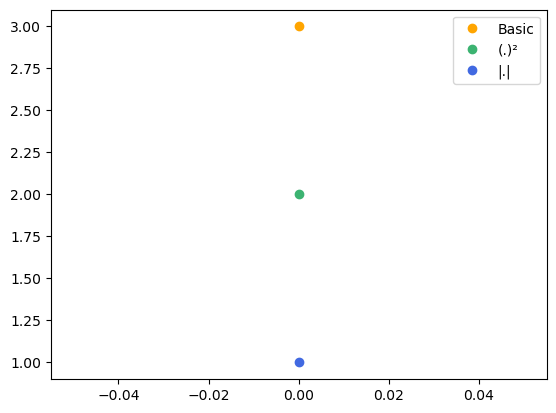

True


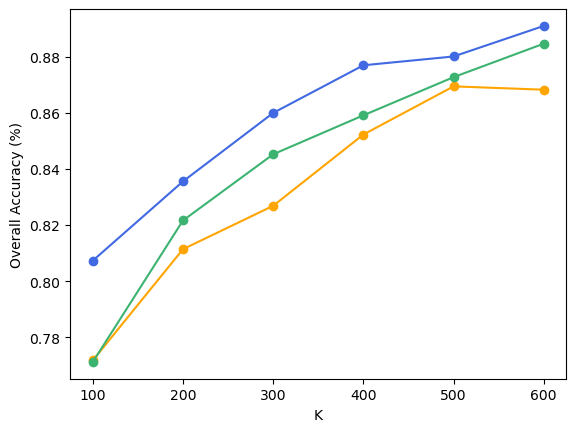

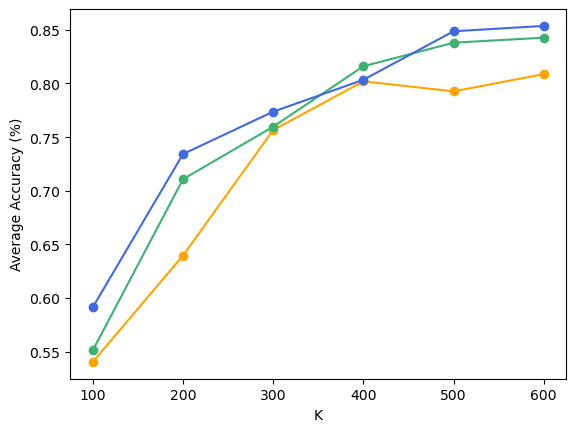

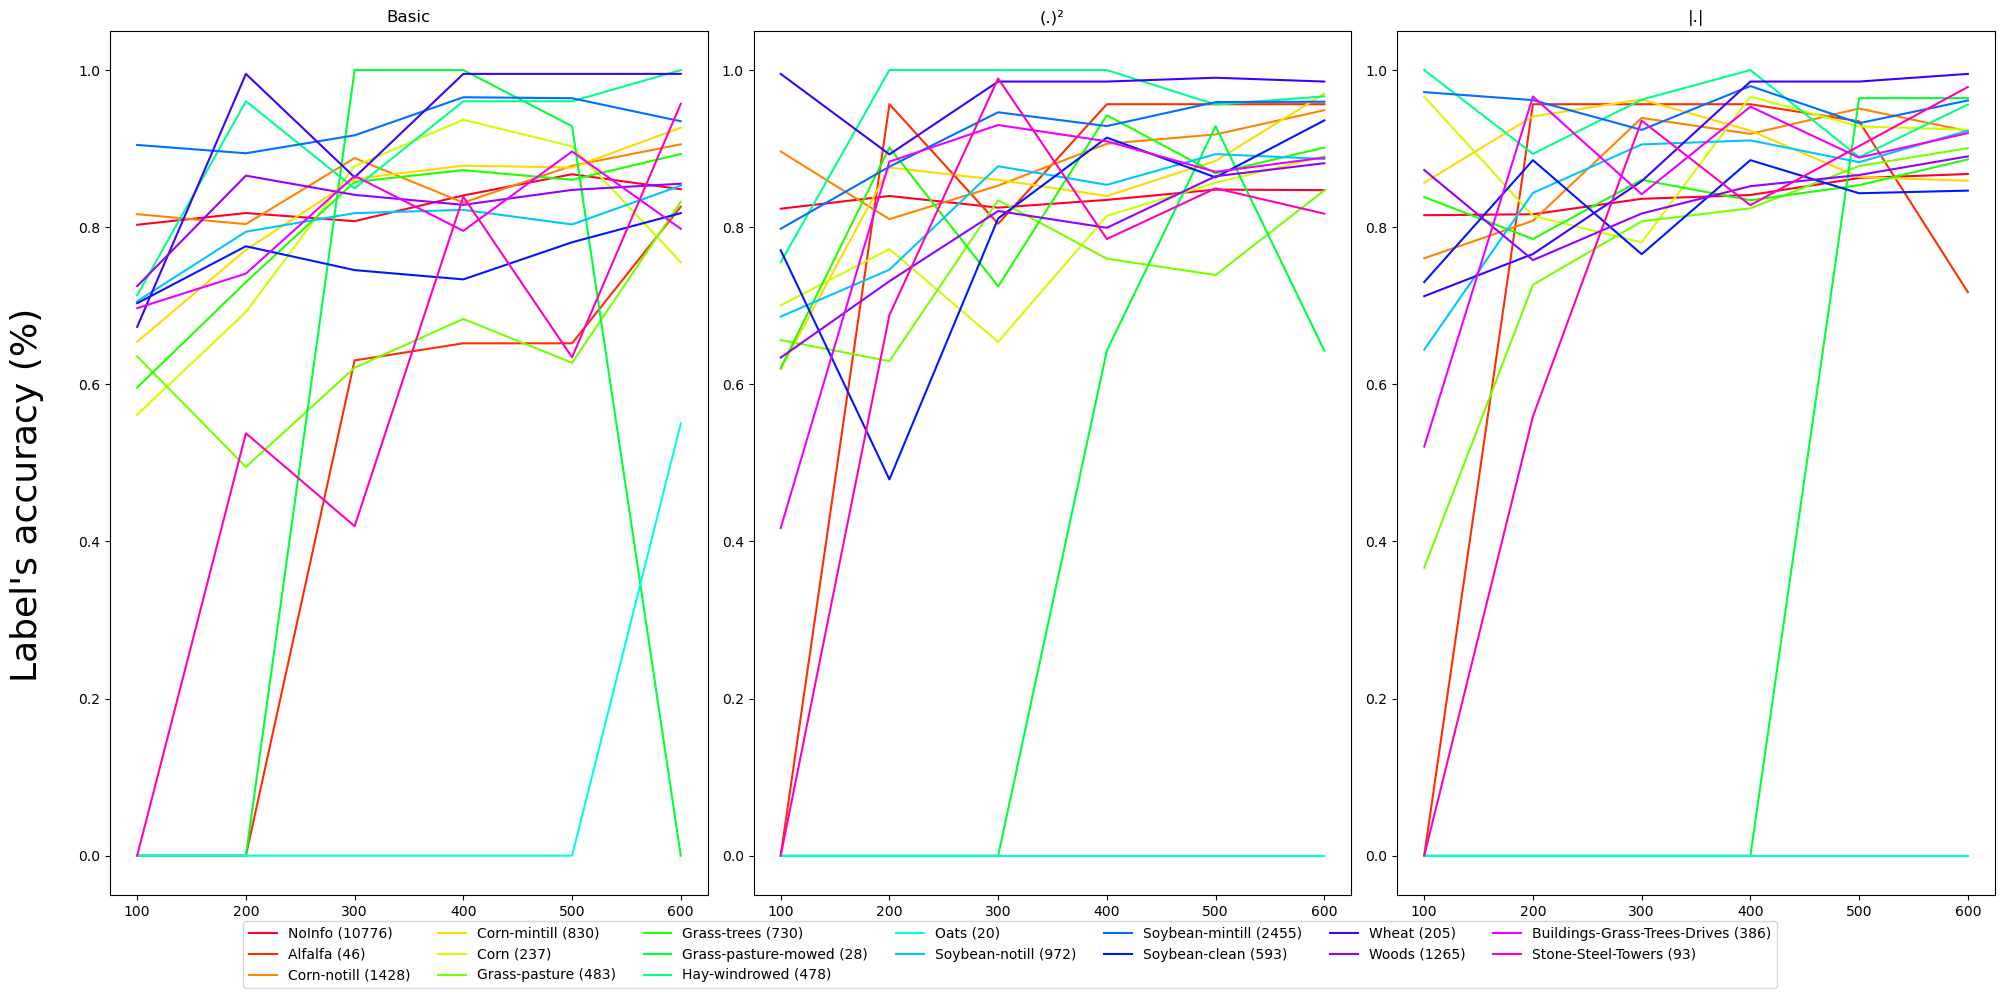

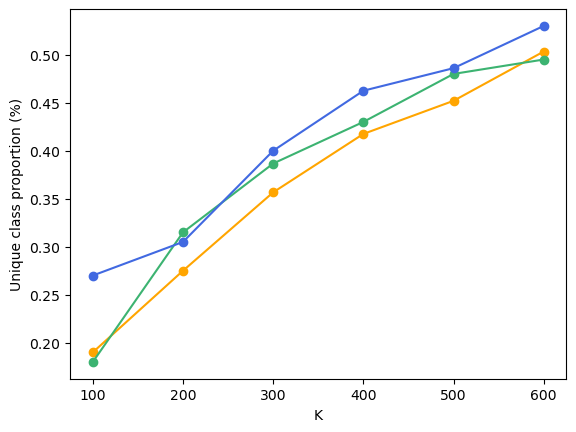

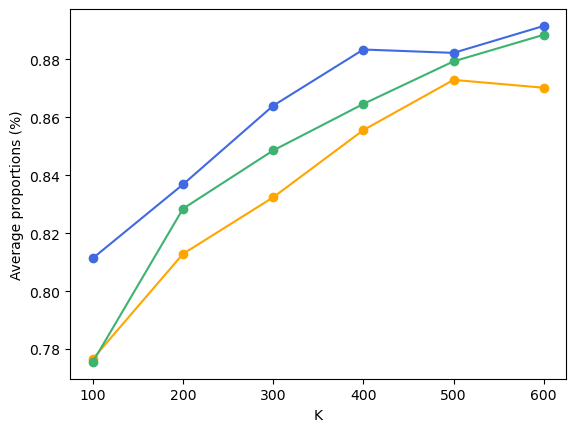

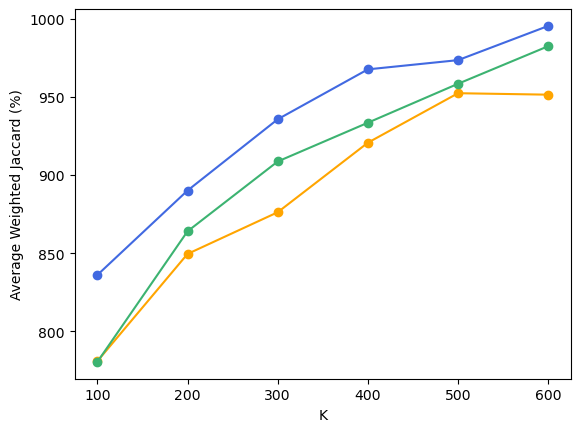

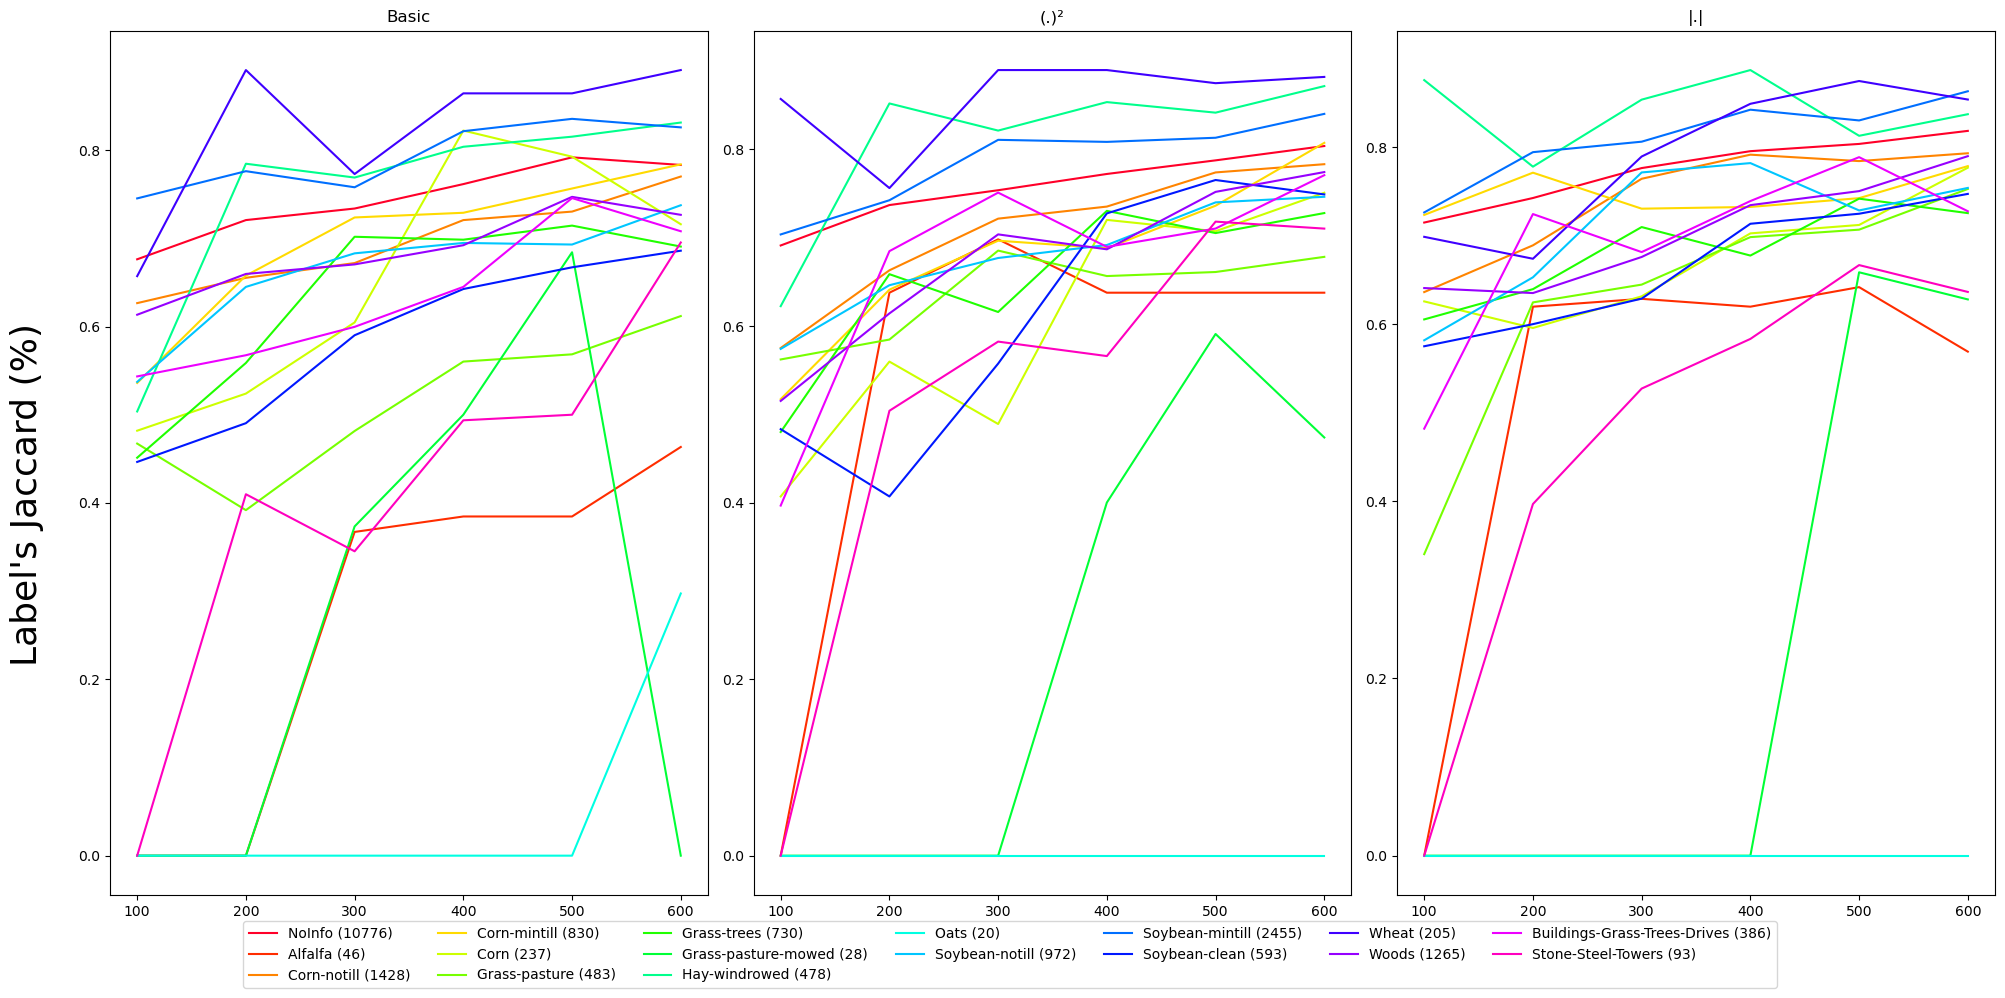

False


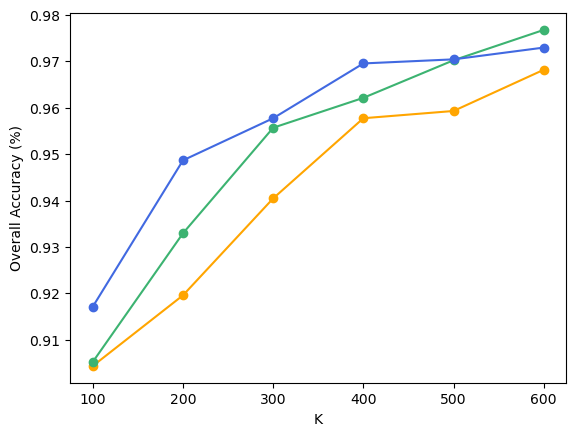

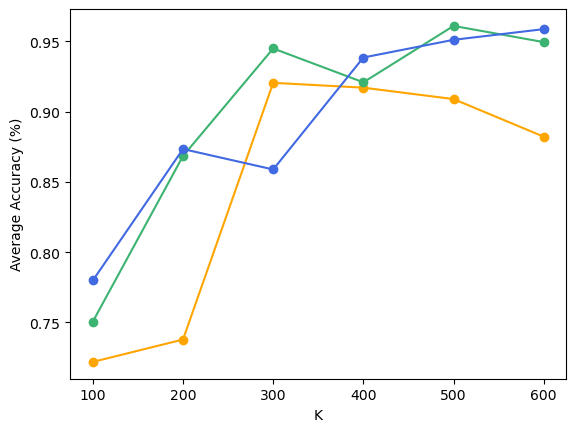

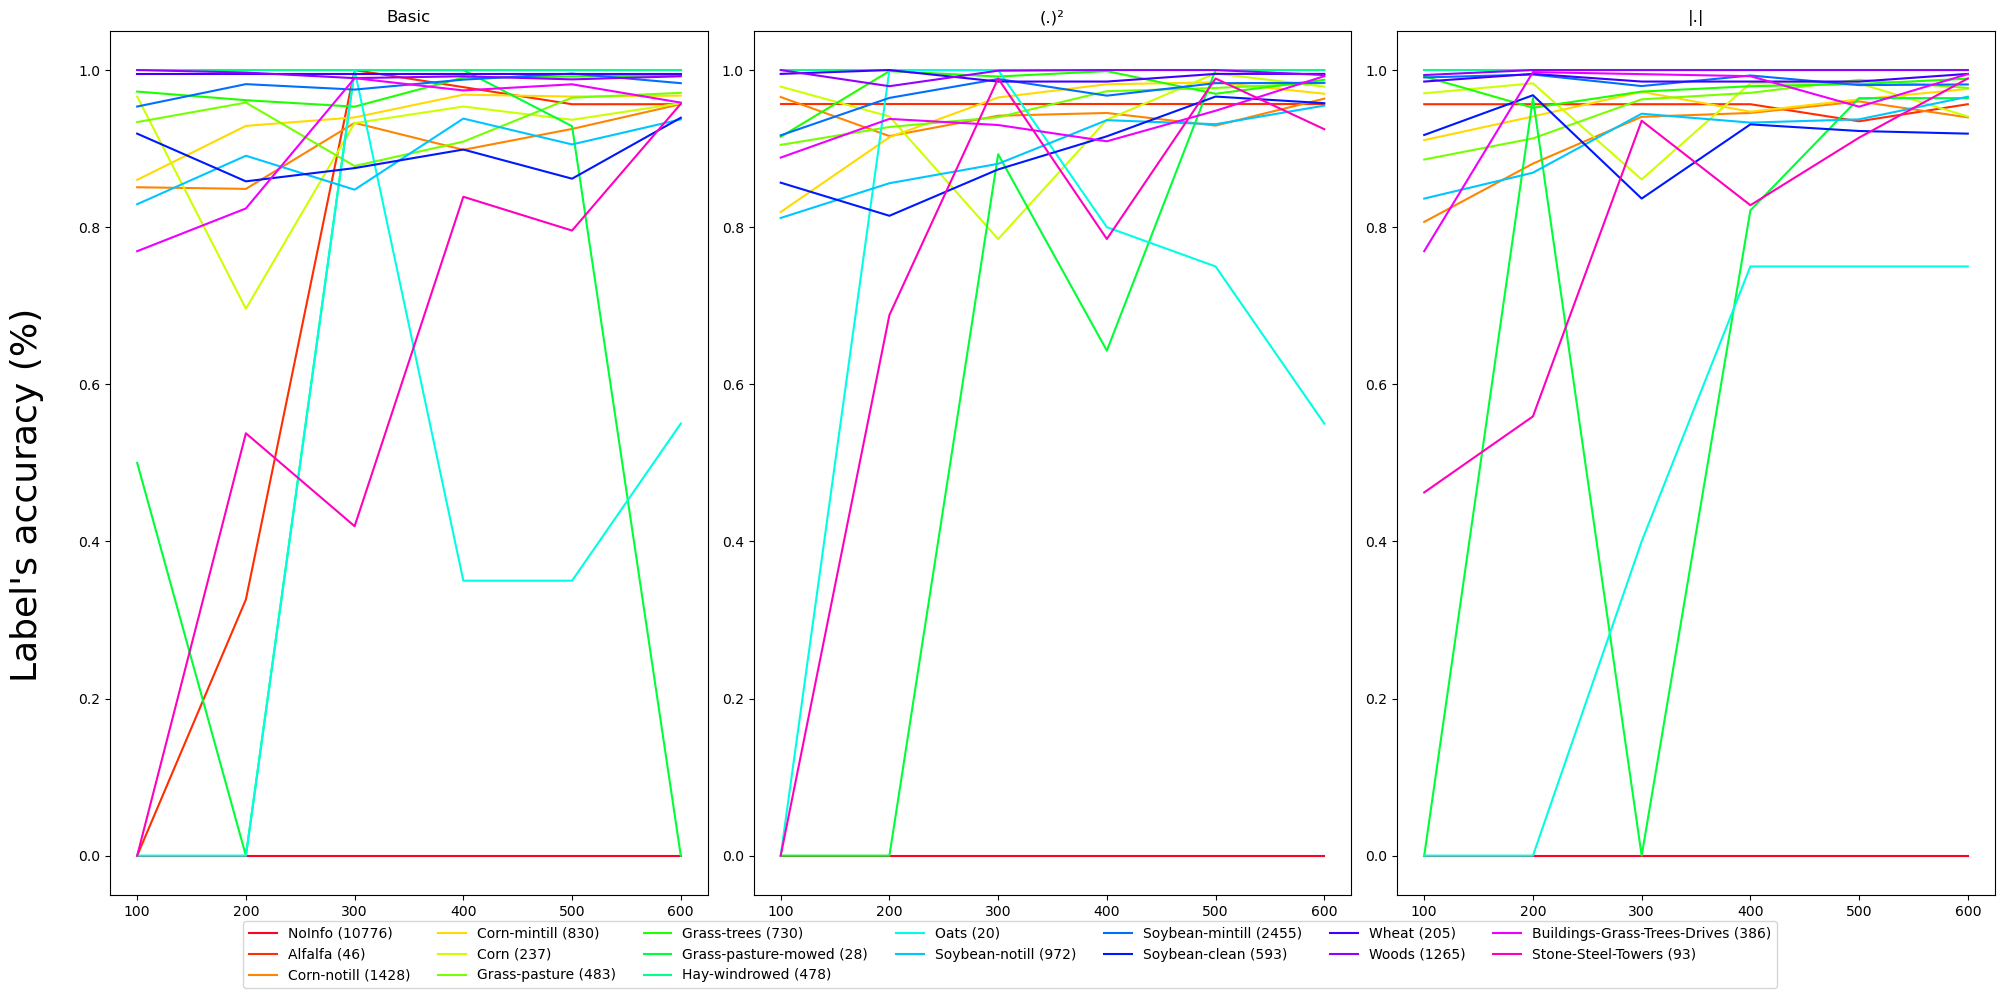

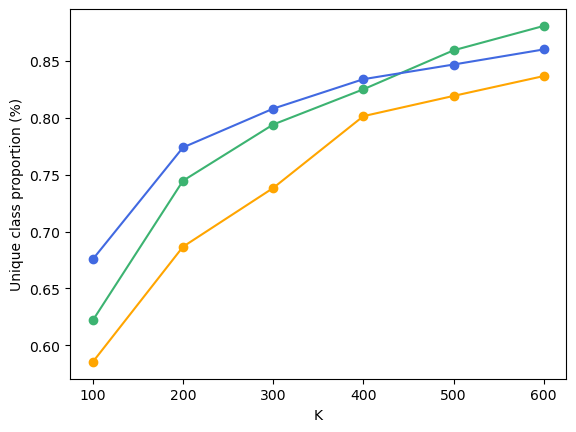

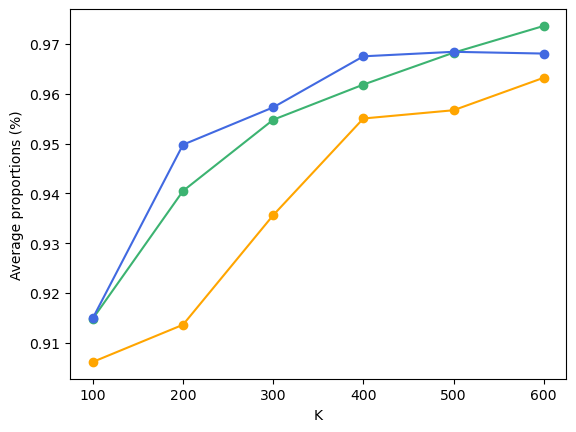

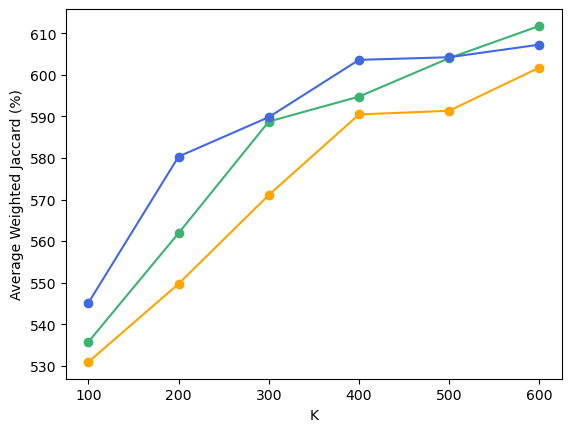

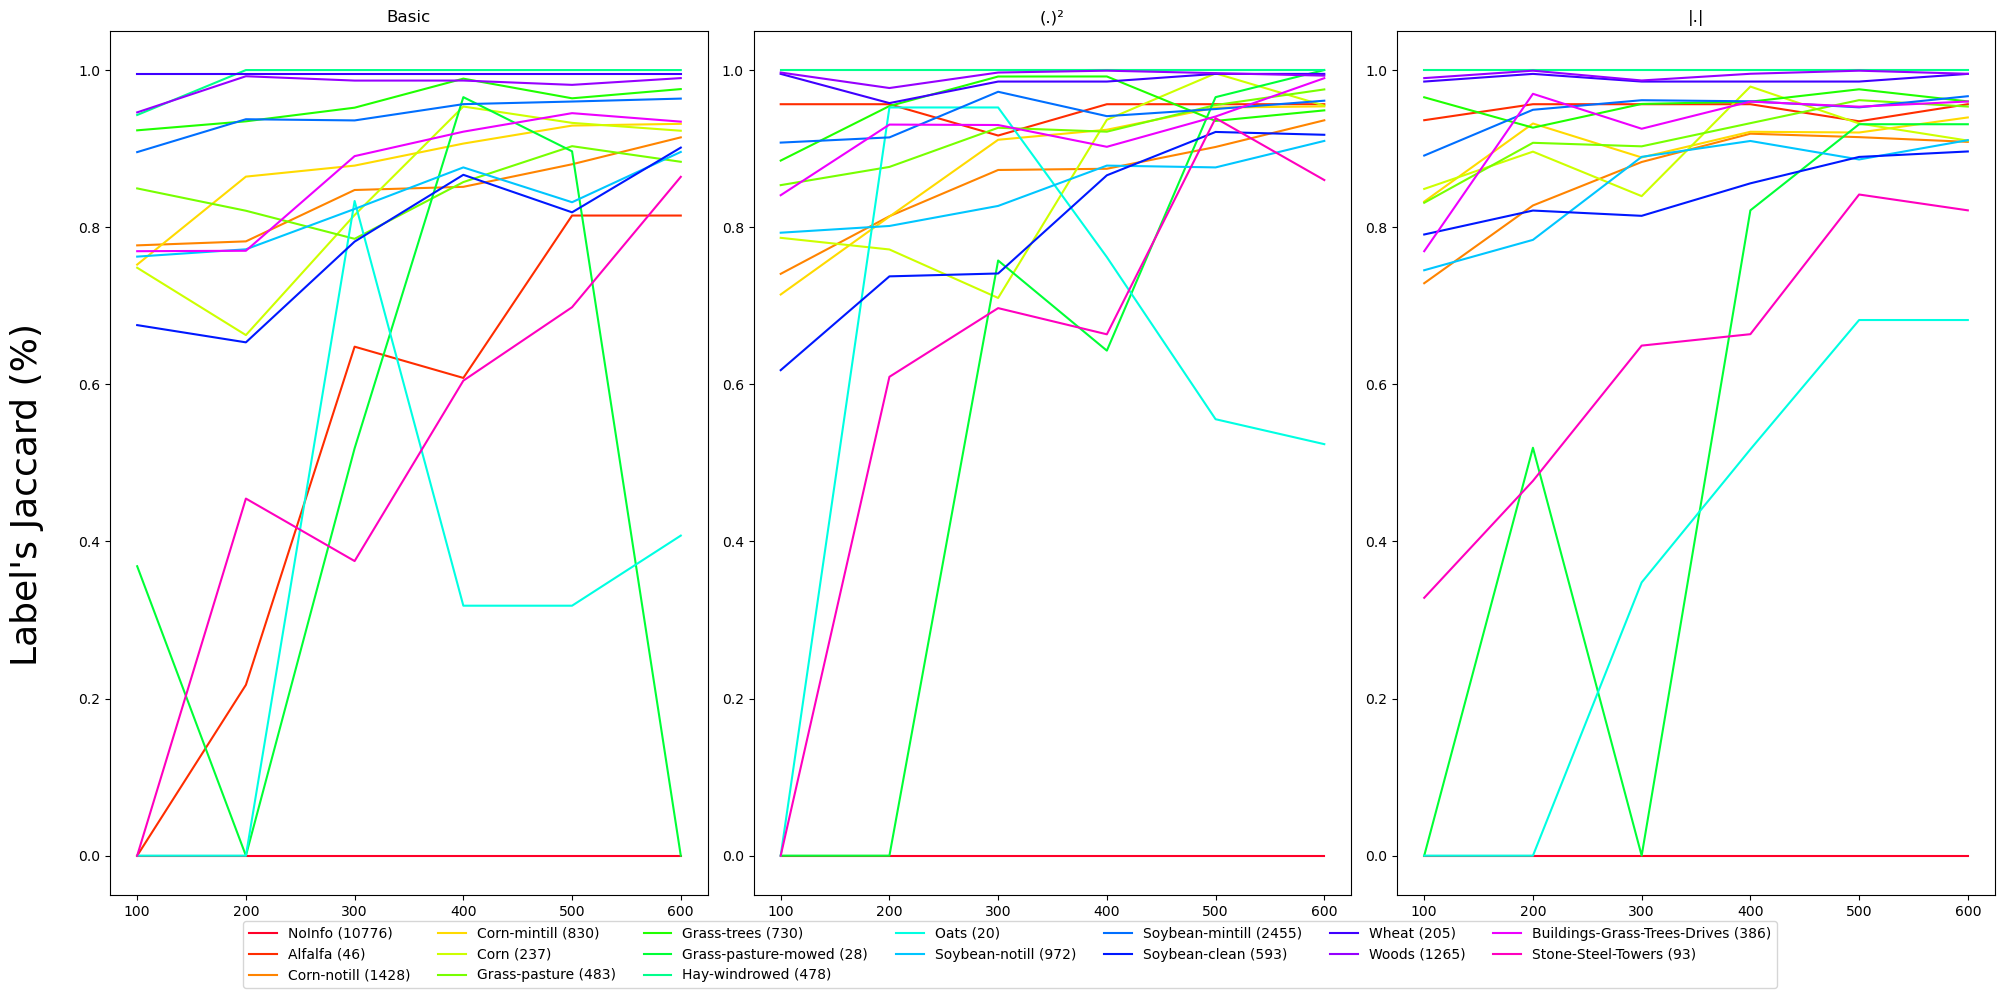

In [10]:
colors = ["orange", "mediumseagreen", "royalblue"]
def plot_info(info, ylabel="", plotbar=False):
    if plotbar:
        for k,K in enumerate(Ks):
            if K!=50:
                for d in range(size):
                    plt.bar(K+ d*20 -20, info[K][d], color=colors[d], width=20)
    else:
        length = len(info[Ks[0]])
        for i in range(length):
            plt.plot(Ks, [info[K][i] for K in Ks], "-o", color=colors[i])
            
    plt.xlabel("K")
    plt.ylabel(ylabel)
    plt.show()


def plot_label_info(info, ylabel=""):
    fig, axs = plt.subplots(1, len(datas), figsize=(20,10), sharex=True)
    for i in range(len(datas)):
        for label in usedDataset["labels"]:
            if label in info.keys():
                axs[i].plot(Ks, [info[label][K][i] for K in Ks], "-",
                            color=labels_color[label],
                            label=usedDataset["class"][label][0]+" ("+str(len(usedDataset["class"][label][1]))+")")
        axs[i].title.set_text(names[i])
    
    fig.text(0.0, 0.5, ylabel, va='center', rotation='vertical', fontsize=26)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.0))

    plt.tight_layout()
    plt.subplots_adjust(left=0.05)  
    plt.subplots_adjust(bottom=0.10)
    plt.show()



for i in range(len(datas)):
    plt.plot(0,len(datas)-i,"o", color=colors[i], label=names[i])
plt.legend()
plt.show()


plotBar = False
motifs = ["-o", "--s", ":^"]
cmap = mpl.colormaps["gist_rainbow"]
labels_color = cmap(np.linspace(0, 1, len(usedDataset["labels"])))
for b in [True, False]:
    print(b)
    plot_info(overallAccuracys[b], "Overall Accuracy (%)", plotbar=plotBar)
    plot_info(averageAccuracys[b], "Average Accuracy (%)", plotbar=plotBar)
    plot_label_info(labelsAccuracy[b], "Label's accuracy (%)")
    plot_info(singleClassCounts[b], "Unique class proportion (%)", plotbar=plotBar)
    plot_info(averageProportions[b], "Average proportions (%)", plotbar=plotBar)
    plot_info(averageWeigthedJaccard[b], "Average Weighted Jaccard (%)", plotbar=plotBar)
    plot_label_info(labelsJaccard[b], "Label's Jaccard (%)")

### GA result

In [11]:
import sklearn.utils
from sklearn.preprocessing import StandardScaler

def split_data(dataset, percent, bands):
    for_slices = [i for i in range(len(bands)) if bands[i]==1]
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    nb_info = sum([len(liste) for key,(_,liste) in dataset["class"].items() if key!=0])
    weights = {}
    for key, (name, liste) in dataset["class"].items():
        if key !=0:
            indices = np.zeros(len(liste), dtype=int)
            indices[:int(len(liste)*percent)] = 1

            np.random.shuffle(indices)

            weights[key] = nb_info/ len(liste)
            
            for i in range(len(liste)):
                data = dataset["data"][liste[i]]
                if indices[i]==1:
                    X_train.append(data[for_slices])
                    y_train.append(key)
                else:
                    X_test.append(data[for_slices])
                    y_test.append(key)

    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
    X_test, y_test = sklearn.utils.shuffle(X_test, y_test, random_state=42)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), weights
   
    


from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def SVM_accuracy(X_train,y_train, X_test,y_test):
    pipeline = Pipeline([
        ('scalar', StandardScaler()),
        ('svc', svm.SVC(kernel='rbf'))
    ])

    param_grid = {
        'svc__C': [0.1, 1, 10, 100, 1000, 2000, 4000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]
    }

    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return len([0 for i in range(len(y_pred)) if y_pred[i]==y_test[i]]) /len(y_pred)


In [13]:
class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1

pourcents = {
    Data.IndianPines["name"]: 0.05,
    Data.PaviaUniversity["name"]: 0.02,
    Data.PaviaCenter["name"]: 0.01
}

best_fitness = {K:[0 for _ in range(len(datas))] for K in Ks}
best_accuracy = {K:[0 for _ in range(len(datas))] for K in Ks}

trainingData = usedDataset["data"]

S_list = {K:[SSGA.compute_Sbsp_Stsp_list(trainData, SPsDic[K][i]) for i in range(len(datas))] for K in Ks}
A = 5
for K in Ks:
    print("K:", K)
    for i in range(len(datas)):
        for a in range(A):
            print(a, end=" ")
            pop, fitness = SSGA.SSGA(trainingData, 9, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2,
                                SP=SPsDic[K][i], S_list=S_list[K][i])
            best_fitness[K][i] += fitness[0]

            bands = pop[0]
            X_train,y_train, X_test,y_test, weights = split_data(usedDataset, pourcents[usedDataset["name"]], bands)
            best_accuracy[K][i] += SVM_accuracy(X_train,y_train, X_test,y_test)

        best_fitness[K][i] /= A
        best_accuracy[K][i] /= A
        print()

KeyboardInterrupt: 

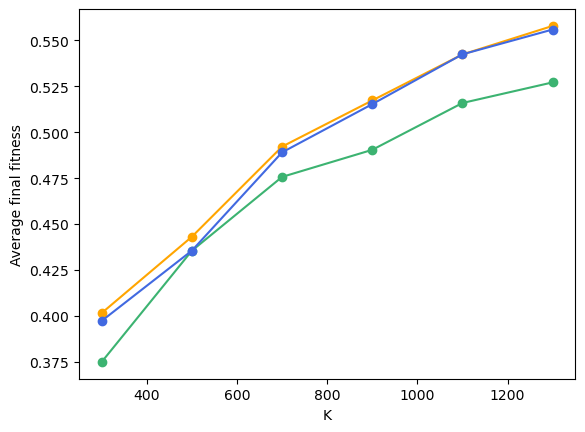

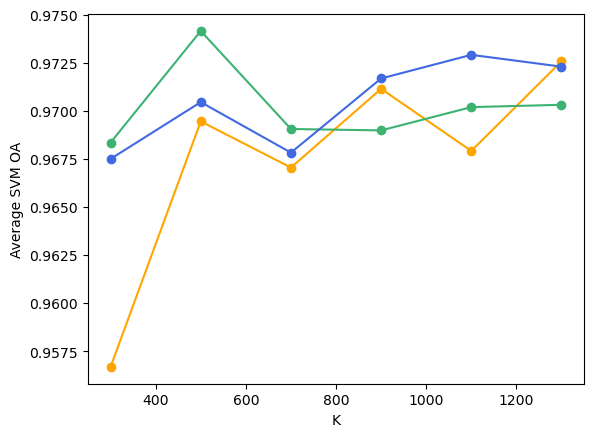

K = 300
[0.9566775977147065, 0.9683426849471969, 0.9674931993427736]
K = 500
[0.9694471525869768, 0.9741500030679656, 0.970447991164259]
K = 700
[0.9670445945853816, 0.9690503623608336, 0.9678204490138194]
K = 900
[0.9711393060943434, 0.9689767311848483, 0.971677904511273]
K = 1100
[0.9679090791330612, 0.9701875549677181, 0.9729064543179913]
K = 1300
[0.9725723869454652, 0.9703089100540643, 0.9722914976444841]


In [ ]:
plot_info(best_fitness, "Average final fitness")
plot_info(best_accuracy, "Average SVM OA")
for K in Ks:
    print("K =", K)
    print(best_accuracy[K])